### Pavement Crack Segmentation

This is a custom model which I have trained on pavement crack images. This model is based on UNet architecture. 

Steps:

1. This model already comes with this repository and it is in the tensorflow (.pb) format. 
2. Use '02_model_conversion.ipynb' notebook to convert this into IR format with FP16 or FP32 precision. 
3. If FP16 is used then we can try to use with either Intel GPU or NCS 2, otherwise FP32 is used with CPU. 

NOTE: OpenVINO for macOS supports inference on Intel CPU and NCS 2 only, not on Intel GPU.

-> In summary, following are the details:
* Model is trained on Tensorflow
* Input size - 352 x 640
* Channel format - RGB

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

%matplotlib inline

#### Define parameters

In [3]:
# Parameters
IMG_SIZE = (352, 640, 3) 

IMG_FPATH = "./images/crack1.jpg"
MODEL_FPATH = "./models/custom_crack_detection/fp32_crack_detection.bin"
ARCH_FPATH = "./models/custom_crack_detection/fp32_crack_detection.xml"

#MODEL_FPATH = "./models/custom_crack_detection/crack_detection.pb" # TF original model

#### Model configuration for the input image

In [4]:
@dataclass
class ModelConfig:
    scalefactor: float = 1.0
    size: tuple = (224, 224)
    mean: tuple = (0, 0, 0)
    swapRB: bool = False
    crop: bool = False
    ddepth: int = cv2.CV_32F

configs = vars(ModelConfig(size=(IMG_SIZE[1], IMG_SIZE[0]), swapRB=True))
print(configs)

{'scalefactor': 1.0, 'size': (640, 352), 'mean': (0, 0, 0), 'swapRB': True, 'crop': False, 'ddepth': 5}


#### Load image, its mask and create a blob

In [5]:
# Load image and prepare a blob which is going to be input to the model
img = cv2.imread(IMG_FPATH)
if img is None:
    raise FileNotFoundError(f'Image not found with the path provided: {IMG_FPATH}')
    
# Get its corresponding mask image (it is used for visual purpose only)
dir_path, fname = os.path.split(IMG_FPATH)
fname = fname.split(".")[0]
mask_fpath = os.path.join(dir_path, "mask_"+fname+".png")

# Load mask/Ground Truth image
mask_img = cv2.imread(mask_fpath)
if mask_img is None:
    raise FileNotFoundError(f'Mask image not found with this path: {mask_fpath}')
    
# Prepare blob
blob = cv2.dnn.blobFromImage(img,
                             scalefactor=configs['scalefactor'],
                             size=configs['size'],
                             mean=configs['mean'],
                             swapRB=configs['swapRB'],
                             crop=configs['crop'],
                             ddepth=configs['ddepth'])

print(blob.shape) # Blob returns in NCHW format

(1, 3, 352, 640)


#### Load model and run inference

In [6]:
# Load model
net = cv2.dnn.readNet(MODEL_FPATH, ARCH_FPATH)
#net = cv2.dnn.readNetFromTensorflow(MODEL_FPATH)

# Specify target device
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
### NOTE: for DNN_TARGET_OPENCL_FP16 (i.e., Intel GPU) it will through error since 
# OpenVINO does not support Intel GPU on macOS.
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU) # DNN_TARGET_OPENCL_FP16

# NOTE: input and output nodes names should be taken from the TF model!!!
net.setInput(blob, name='input_image')
pr_mask = net.forward(outputName='final_conv/Sigmoid')
pr_mask = pr_mask.round() # in the format NCHW

#### Display segmentation results

In [7]:
# helper functions for image, masks and segmentation map visualizations
def denormalize(x):
    """Scale image to range 0..1 for correct plot."""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


def visualize(**images):
    """Plot images in a single row."""
    num_imgs = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_imgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

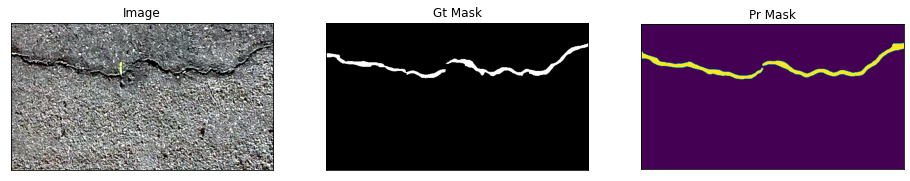

In [8]:
# show the results
visualize(image=denormalize(img.squeeze()),
          gt_mask=mask_img,
          pr_mask=pr_mask[0, ...].squeeze())